# __PHOTOMETRIC STEREO APPLICATION PROJECT__

## Description:

 This is a project to implement a Photometric stereo application. The basic idea of this project is that it allows us to reconstruct a 3D object's surface from 2D images of it under different lighting conditions. Suppose we are in a dark room with an object on a dark table, a camera fixed above it, and a moveable light source. We model the object surface as z = f(x; y), where (x; y) denotes the coordinates on the table and z is the height above the table. Assume that the m x n sized image I is a representation of f(x; y) for each (x; y) tuple. (Given one light source, f(x; y) is the z coordinate of the position where a ray of light hits the surface at (x; y; z).). The pixel intensity I(x; y) indicates how much light reflects of the surface f(x; y). If our object is diffuse (also called matte or Lambertian), one can derive the relationship as,
 
 $\qquad \quad I(x,y) = \alpha (x,y)(l^{T}n(x,y))\qquad \qquad (1)$
 
 where $l\in R^{3}$ is a unit-norm vector describing the orientation of the incident light rays on the surface,
$n(x; y) \in R^{3}$ is the unit-norm surface normal vector of $f$ at $(x, y, f(x, y))$, and $\alpha(x, y) > 0$ is a scaling
constant called the surface albedo.

Now suppose that we take d images $I_{1},\dots, I_{d}$ of our object, with lighting directions $l_{1},\dots,l_{d}$. For any $(x, y)$, we can stack (1) into an overdetermined system of equations.

$\begin{bmatrix}I_{1}(x,y)\\ \vdots \\I_{d}(x,y)\end{bmatrix} \approx \begin{bmatrix}l_{1}\quad \dots \quad l_{d}\end{bmatrix}^{T} (\alpha(x,y)n(x,y)) \qquad \qquad (2)$

which can be written as,

$I_{xy} = L^{T} \rho (x,y)$

This system of equations can be solved for $\rho (x,y)$ when $d\geq 3$ using a least squares solution.

$\rho(x,y) = argmin_{\rho \in R^{3}} ||{I_{xy} - L^{T}\rho}||_{2}^{2}$

The surface norm $n$ is normalized $\rho(x,y)$.

These surface normal vectors can be expressed as 

$n(x,y) = \frac{1}{\sqrt{1 + (\frac{\partial}{\partial x}f(x,y))^{2} + (\frac{\partial}{\partial y}f(x,y))^{2}}} \begin{bmatrix}-\frac{\partial}{\partial x}f(x,y)\\ -\frac{\partial}{\partial y}f(x,y) \\1\end{bmatrix}\qquad \qquad (3)$

where, $\frac{\partial}{\partial x}f(x,y)$ and $\frac{\partial}{\partial y}f(x,y)$ denotes the partial differentiations of $f(x,y)$ w.r.t. $x$ and $y$ respectively. Using the kronecker product we can calculate a matrix $A$ which is a finite-difference approximations to derivatives along x and y. Thus, we get a system of equations as,

$\begin{bmatrix}dfdx \\ dfdy\end{bmatrix} = A \  fxy$

This system can be again solved using least squares approximations as,

$fxy = argmin_{f \in R^{mn}} || \begin{bmatrix}dfdx \\ dfdy\end{bmatrix} - A\ f||_{2}^{2}$

$fxy$ is the surface corresponding to normal vectors $n(x,y)$ 

>Lets start the code for photometric stereo by importing all the required python libraries.

In [1]:
import numpy as np
from scipy import linalg
from scipy import optimize as op
import scipy.sparse as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.simplefilter('ignore')


>Initialize required constants. In this code we are just defining the number of iterations for our least squares.

In [2]:
#Initializations
nIters = 1000

> The ```normalize``` function returns a normalized value of input numpy array ```X``` along the input dimension ```dim```.

In [3]:
def normalize(X, dim):
    x2_sum = np.sum(np.power(X,2),dim)
    norms = np.sqrt(x2_sum)
    Xn = X/norms
    return Xn

>The ```diffs_2d``` function returns a 2D differential matrix ```A```. It computes finite-difference approximations to derivatives along x and y. In this case for dimensions ```m``` and ```n```. It is sparse in nature.

In [4]:
def diffs_2d(m,n):
    b1 = -np.matlib.ones((n,1),float)
    b2 = np.matlib.ones((n,1),float)
    B = np.array(np.concatenate((b1,b2),axis=1))
    Dn = sp.spdiags(B.T,np.array([0,1]),n,n)
    Dn = Dn.tolil()
    Dn[n-1,0] = 1
    c1 = -np.matlib.ones((m,1),float)
    c2 = np.matlib.ones((m,1),float)
    C = np.array(np.concatenate((c1,c2),axis=1))
    Dm = sp.spdiags(C.T,np.array([0,1]),m,m)
    Dm = Dm.tolil()
    Dm[m-1,0] = 1
    A1 = sp.kron(Dn,sp.eye(m))
    A2 = sp.kron(sp.eye(n),Dm)
    A = sp.vstack((A1,A2))
    return A
    

>The ```compute_normals``` function computes the normals of intensity ```I``` along a unit-norm vector ```L``` describing the orientation of the incident light rays on the surface. 

In [5]:
def compute_normals(I,L):
    m,n,d = np.shape(I)
    I_vec = I.reshape(m*n,d)
    L_norm = normalize(L,0)
    g = np.array(linalg.lstsq(L_norm.T,I_vec.T))
    g = g[0]
    g = np.reshape(g,(3,m,n))
    N = normalize(g,0)
    return N

>Now, as all the required functions are defined, lets proceed with loading the data.

In [6]:
catData = sio.loadmat('./cat.mat')
I = catData['I']
L = catData['L']
M = catData['M']
m,n,d = np.shape(I)

>Lets compute normals matrix ```N``` using previously defined ```compute_normals``` function on the loaded data.

In [7]:
N = compute_normals(I,L)
print(N.shape)

(3, 550, 430)


>Lets plot the computed normals matrix ```N```.

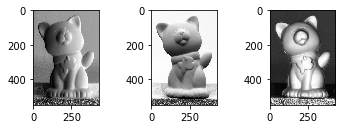

In [8]:
fig = plt.figure(frameon=False)
plt.subplot(131)
plt.imshow(N[0],cmap=plt.cm.gray,aspect=2*0.5625, interpolation='nearest')
plt.subplot(132)
plt.imshow(N[1],cmap=plt.cm.gray,aspect=2*(0.5625), interpolation='nearest')
plt.subplot(133)
plt.imshow(N[2],cmap=plt.cm.gray, aspect=2*0.5625, interpolation='nearest')
plt.subplots_adjust(left=0.2, wspace=0.8, top=1)
plt.show()

>The generated normals matrix is now separated into ```DFDX``` for calculating the x-gradients and ```DFDY``` for calculating the y-gradients

In [9]:
DFDX = -N[0] / N[2]
DFDY = N[1] / N[2]

DFDX_nan = np.isnan(DFDX)
DFDX_mask = DFDX_nan | ~M.astype(bool)
DFDX_mk = np.ma.masked_array(DFDX,mask=DFDX_mask)
DFDX = DFDX_mk.filled(fill_value=0)

DFDY_nan = np.isnan(DFDY)
DFDY_mask = DFDY_nan | ~M.astype(bool)
DFDY_mk = np.ma.masked_array(DFDY,mask=DFDY_mask)
DFDY = DFDY_mk.filled(fill_value=0)

>As differential matrix is generated, the least squares solution is calculated to find the depth matrix

In [10]:
A = diffs_2d(m,n)
b = np.array(np.concatenate((DFDX.flatten(1),DFDY.flatten(1)),axis=0))
b = b.reshape(473000,1)
print('Shape of sparse matrix A:',A.shape)
print('Shape of vectorized differtial matrix b:',b.shape)
fxy = sp.linalg.lsqr(A,b,iter_lim=nIters)

Shape of sparse matrix A: (473000, 236500)
Shape of vectorized differtial matrix b: (473000, 1)


>Now, the least squares solution is calculated for the normals and it is differentiated to form a depth surface. This variable is now cleaned(normalized) and mask is applied to the surface. Due to normalization, the function becomes anchored to z-axis.

In [11]:
FXY = np.reshape(fxy[0],(n,m))
FXY_mask = M
FXY_masked = np.ma.masked_array(FXY.T,mask=FXY_mask)
FXY_masked = FXY_masked.filled(fill_value=99)
FXY = FXY.T - min(FXY_masked.flatten())
FXY = FXY*M
print('Shape of FXY: ',FXY.shape)

Shape of FXY:  (550, 430)


>The ```FXY``` formed in the above section is the 3D surface of the cat object that we set out to find. That variable is plotted in the below section.

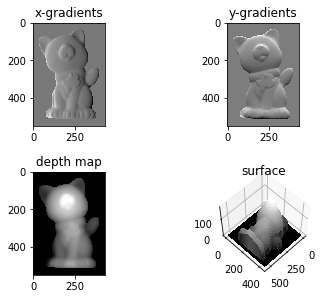

In [12]:
fig = plt.figure(frameon=False)
plt.subplot(221)
plt.title('x-gradients')
plt.imshow(DFDX,cmap=plt.cm.gray,aspect=2*0.5625, interpolation='nearest')
plt.subplot(222)
plt.title('y-gradients')
plt.imshow(DFDY,cmap=plt.cm.gray,aspect=2*(0.5625), interpolation='nearest')
plt.subplot(223)
plt.title('depth map')
plt.imshow(FXY,cmap=plt.cm.gray, aspect=2*0.5625, interpolation='nearest')
ax = fig.add_subplot(224, projection='3d')
xx, yy = np.mgrid[0:FXY.shape[0], 0:FXY.shape[1]]
ax.plot_surface(xx,yy,FXY,cmap=plt.cm.gray,linewidth=0, antialiased=False)
ax.azim = 45
ax.elev = 60
plt.title('surface')
plt.subplots_adjust(left=0.2, wspace=0.8, top=1,hspace=0.45)
plt.show()

>The 4th subplot is not properly visible in the above plot. The same subplot is shown below. The parameters ```ax.azim``` and ```ax.elev``` can be varied to change the perspective and look at the 3D surface.

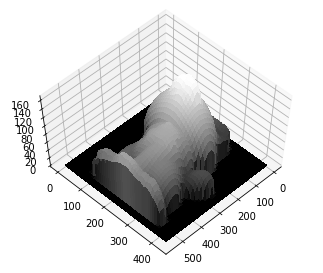

In [13]:
fig = plt.figure(frameon=False)
ax = fig.gca(projection='3d')
xx, yy = np.mgrid[0:FXY.shape[0], 0:FXY.shape[1]]
ax.plot_surface(xx,yy,FXY,cmap=plt.cm.gray,linewidth=0, antialiased=False)
plt.subplots_adjust(left=0.2, wspace=0.8, top=1)
ax.azim = 45 #Vary this parameter to change the perspective
ax.elev = 60 #Vary this parameter to change the perspective
plt.show()

>This generated ```FXY``` variable can be directly saved to a stl file and printed from a 3D printer. This ends the project of Photometric Stereo in Python.